In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'png'
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.marker'] = '^'

In [2]:
# Number of time steps
nt = 12

# Number of testing data
num_data = 200

# Number of branches
num_branches = 186

# Power flow limit
file_path = f'../../data/IEEE_Case118/branch_params/PF_max_category1.csv'
PF_max_category1 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()
file_path = f'../../data/IEEE_Case118/branch_params/PF_max_category2.csv'
PF_max_category2 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()
file_path = f'../../data/IEEE_Case118/branch_params/PF_max_category3.csv'
PF_max_category3 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()

epsilon = 0.85

PF_max1 = 100
PF_max2 = 200
PF_max3 = 400

PF_threshold = np.zeros((num_branches, nt))
PF_threshold[PF_max_category1, :] = epsilon * PF_max1
PF_threshold[PF_max_category2, :] = epsilon * PF_max2
PF_threshold[PF_max_category3, :] = epsilon * PF_max3

# Matrix to store results
PF_res_true = np.zeros((num_data, num_branches, nt))
PF_res_pred = np.zeros((num_data, num_branches, nt))

In [3]:
# Read PF file
for i in range(num_data):
    # Ground truth
    file_path = f'model_evaluation/PF_true/true_{i+1}.csv'
    PF_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    res = (np.abs(PF_true) >= PF_threshold)
    PF_res_true[i] = res.copy()

    # Prediction
    file_path = f'model_evaluation/PF_pred/pred_{i+1}.csv'
    PF_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    res = (np.abs(PF_pred) >= PF_threshold)
    PF_res_pred[i] = res.copy()

PF_res_true = PF_res_true.astype(float)
PF_res_pred = PF_res_pred.astype(float)

In [4]:
np.sum(np.sum(np.sum(PF_res_true))), np.sum(np.sum(np.sum(PF_res_pred)))

(17438.0, 14002.0)

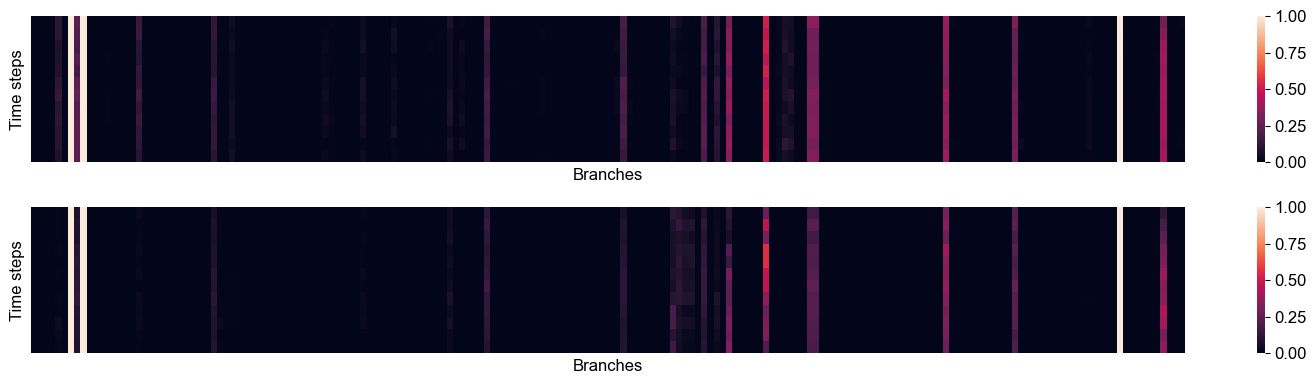

In [5]:
# Probability of heavying loading
prob_true = PF_res_true.mean(axis=0)
prob_pred = PF_res_pred.mean(axis=0)

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(211)
sns.heatmap(prob_true.T, 
            ax=ax1,
            vmin=0,
            vmax=1,
            xticklabels=[],
            yticklabels=[])
ax1.set_xlabel('Branches')
ax1.set_ylabel('Time steps')

ax2 = fig.add_subplot(212)
sns.heatmap(prob_pred.T, 
            ax=ax2,
            vmin=0,
            vmax=1,
            xticklabels=[],
            yticklabels=[])
ax2.set_xlabel('Branches')
ax2.set_ylabel('Time steps')

plt.tight_layout()
plt.show()
plt.close('all')

##### Select important branches

In [6]:
# Get sorted branch index according to mean probability of ground truth
sorted_idx = np.argsort(prob_true.T.mean(axis=0))

# Select six important branches
num_top_branches = 12
top_branch_idx = sorted_idx[-num_top_branches:]

# Sort top branch index
# top_branch_idx = np.sort(top_branch_idx)

top_branch_idx

array([108,   7, 158, 126, 125, 112, 147, 182, 118,   8,   6, 175])

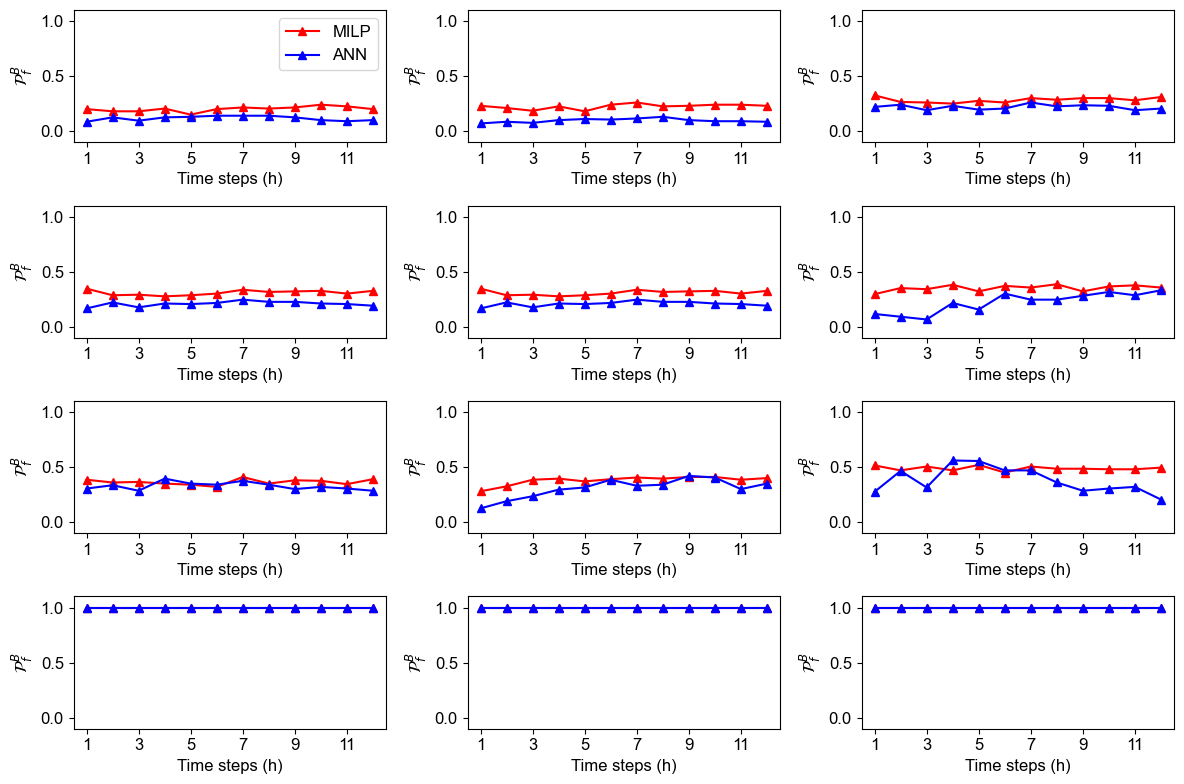

In [7]:
# Plot probability for individual branch
x = np.arange(1, 13)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(4, 3, 1)
ax1.plot(x, prob_true[top_branch_idx[0], :], color='red', label='MILP')
ax1.plot(x, prob_pred[top_branch_idx[0], :], color='blue', label='ANN')
ax1.set_xlim((0.5, 12.5))
ax1.set_xticks(np.arange(1, 13, 2))
ax1.set_ylim((-0.1, 1.1))
ax1.set_xlabel('Time steps (h)')
ax1.set_ylabel('$\mathcal{P}^B_f$')
ax1.legend()

for i in range(1, num_top_branches):
    ax = fig.add_subplot(4, 3, i+1)
    ax.plot(x, prob_true[top_branch_idx[i], :], color='red')
    ax.plot(x, prob_pred[top_branch_idx[i], :], color='blue')
    ax.set_xlim((0.5, 12.5))
    ax.set_xticks(np.arange(1, 13, 2))
    ax.set_ylim((-0.1, 1.1))
    ax.set_xlabel('Time steps (h)')
    ax.set_ylabel('$\mathcal{P}^B_f$')


plt.tight_layout()
plt.show()
plt.close('all')